## １. ライブラリのインポート

以下を実行してライブラリをインポート

In [12]:
import serial
import csv
import os
from datetime import datetime
import threading
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import pandas as pd

## 2. ファイル名の設定
出力されるCSVとPNGのファイル名を設定

student_idを仕様に合わせて設定

In [13]:
student_id = '026'      #自分の学籍番号の下3桁を設定

file_name = f'b3_{student_id}_pulse' #上記の設定により自動でファイル名が設定される

## ３. シリアル通信によるデータの読み込み
port='/dev/tty'の y と ' の間にカーソルを合わせ . を入力すると候補が表示されるので，usbmodem.....を選択
実行後にArduinoからの信号待ち状態に入る

eを入力し，Enterで終了するとそれまでにArudinoから送信されたデータがファイルに出力される

In [54]:
#################### シリアルポートの設定 #########################
##修正箇所：ttyの後ろに.を入力すると候補が表示されるのでusbmodemの方を選択（数値は各々のMacやArduinoによって異なる）
##例：ser = serial.Serial(port='/dev/tty.usbmodem4827E2E0D9D02', baudrate=115200, timeout=1) 
ser = serial.Serial(port='/dev/tty.usbmodem34B7DA61F2202', baudrate=115200, timeout=1)  


###################  これ以降は修正の必要はない  ###################
data = []
exit_flag = False

def save_to_csv(data):
    with open(f'{file_name}.csv', 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerows(data)    

def log_to_file(port):
    current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S.%f")[:-3]  # ミリ秒まで取得
    log_data = [current_time, port, file_name]
    log_file = f'b3_{student_id}_log.csv'
    try:
        with open(log_file, 'x', newline='') as log:
            writer = csv.writer(log)
            writer.writerow(["Timestamp", "Port", "OutputFile"])  # ヘッダー行
            writer.writerow(log_data)
    except FileExistsError:
        with open(log_file, 'a', newline='') as log:
            writer = csv.writer(log)
            writer.writerow(log_data)
            
def read_serial():
    global exit_flag

    while not exit_flag:
        if ser.in_waiting > 0:
            
            line = ser.readline().decode('utf-8').rstrip()
            print(line, flush=True)

            parsed_line = line.replace('",', ',').replace('"', '')
            parts = parsed_line.split(',')
            
            if len(parts) == 2:
                data.append([parts[0].strip(), parts[1].strip()])

def wait_for_exit():
    global exit_flag
    while not exit_flag:
        # キー入力を待機
        if input() == 'e':
            exit_flag = True
            save_to_csv(data)
            log_to_file(ser.port)
            print("終了キーが押されました。データを保存して終了します。")

print("シリアル通信の読み込み開始，Arduinoのリセットボタンを押して下さい．", flush=True)
print("ArduinoのTX LEDが消灯後，eを入力しEnterで終了し，ファイルが出力されます", flush=True)

input_thread = threading.Thread(target=wait_for_exit)
input_thread.start()
read_serial()
input_thread.join()
ser.close()

シリアル通信の読み込み開始，Arduinoのリセットボタンを押して下さい．
ArduinoのTX LEDが消灯後，eを入力しEnterで終了し，ファイルが出力されます
time,pulse
0.00,69
1.72,65
3.60,60
5.52,65
7.40,63
9.20,65
11.10,61
12.98,69
14.76,63
16.56,66
18.42,61
20.34,66
22.18,62
24.02,68
25.82,62
27.76,63
29.62,63
31.52,69
33.30,62
35.24,66
37.00,65
38.86,68
40.64,62
42.56,62
44.40,62
46.32,68
48.08,65
49.96,61
51.86,65
53.74,62
55.56,66
57.44,61
59.32,69
終了キーが押されました。データを保存して終了します。


## ４. 図の描画

CSVの出力を元にグラフを作成して画像ファイル(PNG形式)で出力する
2. ファイル名の設定で設定した名前に基づいてcsvの読み込みと，pngの出力が行われる

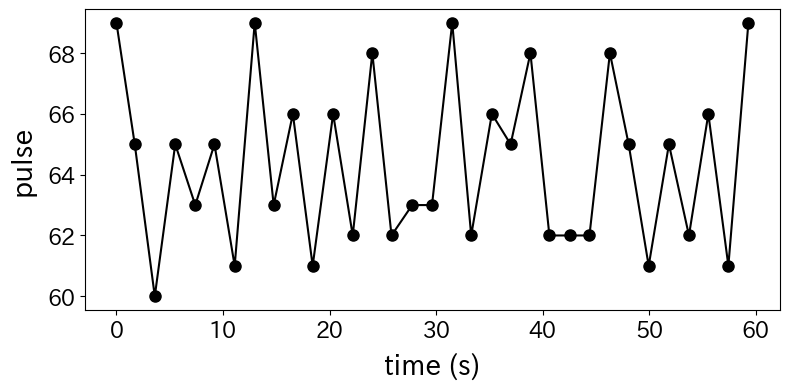

In [55]:
fig = plt.figure(figsize=(8, 4))
ax = fig.subplots()

data = pd.read_csv(f"{file_name}.csv")  

t = data['time'].values
v = data['pulse'].values

ax.plot(t, v, marker='o', color='#000000', linestyle="-", markersize=8)

ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.xaxis.labelpad = 8
ax.yaxis.labelpad = 8
ax.set_xlabel("time (s)", fontsize=20)
ax.set_ylabel("pulse", fontsize=20)

plt.tight_layout()
plt.savefig(f"{file_name}.png") 
plt.show()